# Aim
Ilustrate Survival Analysis Analysis.
Using relevant cases with examples, in this case dataset for South Corea cases of Covid19.

# Conclusions

1. Sample is very small.
2. Median time for decease is 4 days.
3. There are not significant differences in terms of gender for deceases in terms of the time. Males and Females appears to be affected at the same path. Proportions of females with the disease appears to be smallers. Sample size very small.
4. The same for people of different ages. However the number of people recorded is strongly affected by age. Potential Selection Bias. Sample size very small.
4. People with previous diseases/conditions die sooner.


# Literature
## Key ideas
* **Survival Analysis**: Survival analysis is a branch of statistics for analyzing the expected duration of time until one or more events happen, such as death in biological organisms and failure in mechanical systems. This topic is called reliability theory or reliability analysis in engineering, duration analysis or duration modelling in economics, and event history analysis in sociology. Survival analysis attempts to answer questions such as: what is the proportion of a population which will survive past a certain time? Of those that survive, at what rate will they die or fail? Can multiple causes of death or failure be taken into account? How do particular circumstances or characteristics increase or decrease the probability of survival? From https://en.wikipedia.org/wiki/Survival_analysis
* **Logrank test**: is a hypothesis test to compare the survival distributions of two samples. From  https://en.wikipedia.org/wiki/Logrank_test 
## Papers
1. Wu C, Chen X, Cai Y, et al. Risk Factors Associated With Acute Respiratory Distress Syndrome and Death in Patients With Coronavirus Disease 2019 Pneumonia in Wuhan, China. JAMA Intern Med. Published online March 13, 2020. doi:10.1001/jamainternmed.2020.0994
    * Particular interesting because of the case
    
    <img src="../papers/Wu_et_al_2020.png" width="350" height="450" />
## Libraries
# R
# Python
* [Lifelines](https://lifelines.readthedocs.io/en/latest/Quickstart.html)

# Blogs

1. Overall view in Python:
    * https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
2. Examples in R and Python: https://plot.ly/python/v3/ipython-notebooks/survival-analysis-r-vs-python/

# Data
From [Kagle](https://www.kaggle.com/kimjihoo/coronavirusdataset)

In [1]:
import sys
import os
from tqdm import tqdm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
sys.path.insert(0, os.path.abspath('../../covid_forecast'))
from covid_forecast.utils.data_io import get_data, download_the_data
from covid_forecast.utils.visualizations import plt_arima_forecast,plt_arima_forecast_outsample, render_pic_in_notebook
import numpy as np
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
%matplotlib inline
import matplotlib.pyplot as plt
from lifelines.utils import median_survival_times
from lifelines import WeibullFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

# where to save things
OUTPUT = '../outputs/survival_analysis'
# Data from SK, https://www.kaggle.com/kimjihoo/coronavirusdataset#PatientInfo.csv
DATA_LOCATTION = '../data/coronavirusdataset/PatientInfo.csv'
os.makedirs(OUTPUT,exist_ok=True)

In [2]:
data = pd.read_csv(DATA_LOCATTION)
data = data[[i for i in data.columns if not i.__contains__('Unnamed')]]
data.head().T

,0,1,2,3,4
patient_id,1000000001,1000000002,1000000003,1000000004,1000000005
global_num,2,5,6,7,9
sex,male,male,male,male,female
birth_year,1964,1987,1964,1991,1992
age,50s,30s,50s,20s,20s
country,Korea,Korea,Korea,Korea,Korea
province,Seoul,Seoul,Seoul,Seoul,Seoul
city,Gangseo-gu,Jungnang-gu,Jongno-gu,Mapo-gu,Seongbuk-gu
disease,NaN,NaN,NaN,NaN,NaN
infection_case,overseas inflow,overseas inflow,contact with patient,overseas inflow,contact with patient


Text(0.5, 1.0, 'Patients states')

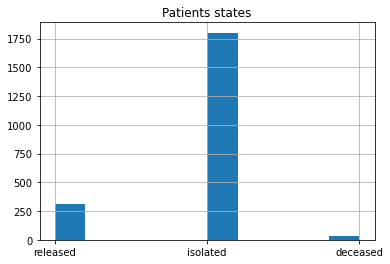

In [41]:
data['state'].hist()
plt.gcf()
plt.title('Patients states')

In [4]:
"""Check numbers death, recovered and sick"""
print('Size sample: {}'.format(data.shape[0]))
print('Number casualties {}'.format((data['state'] == 'deceased').sum()))
print('Number recovered {}'.format((data['state'] == 'released').sum()))

Size sample: 2243
Number casualties 32
Number recovered 314


# Features

In [5]:
data['confirmed_date'] = pd.to_datetime(data['confirmed_date'])
data['released_date'] = pd.to_datetime(data['released_date'])
data['symptom_onset_date'] = pd.to_datetime(data['symptom_onset_date'])
data['deceased_date'] = pd.to_datetime(data['deceased_date'])
#data['duraction_confirmed_death'] = data['released_date']-data['confirmed_date']
data['days_death_confirmed'] = data['deceased_date']-data['confirmed_date']
data['days_death_symptons'] = data['deceased_date']-data['symptom_onset_date']

Considering people sick
Maximum data on the dataset, to calculated durations.

In [6]:
max_date_on_dataset = max([data['released_date'].max(), data['deceased_date'].max()])
max_date_on_dataset

Timestamp('2020-03-20 00:00:00')

In [7]:
def create_starting_date(patient_data):
    """
    Create starting date checking first sysmptoms but taking
    confirmed_date if not availabe
    """
    if pd.isnull(patient_data['symptom_onset_date']):
        return patient_data['confirmed_date']
    else:
        return patient_data['symptom_onset_date']
    
data['start_date'] = data.apply(lambda x: create_starting_date(x), axis = 1)
data['start_date'].describe()

count                    2098
unique                     49
top       2020-03-01 00:00:00
freq                      129
first     2020-01-19 00:00:00
last      2020-03-20 00:00:00
Name: start_date, dtype: object

In [8]:
def create_end_date(patient_data,max_date_on_dataset = '2020-03-20 00:00:00'):
    """
    Create ending date checking first sysmptoms but taking
    confirmed_date if not availabe
    """
    if patient_data['state'] == 'isolated':
        return max_date_on_dataset
    elif patient_data['state'] == 'deceased':
        return patient_data['deceased_date'] 
    elif patient_data['state'] == 'released':
        return patient_data['released_date']
    else:
        return None

data['end_date'] = data.apply(lambda x: create_end_date(x), axis = 1)
data['end_date'].describe()

count                    2061
unique                     38
top       2020-03-20 00:00:00
freq                     1806
first     2020-02-05 00:00:00
last      2020-03-20 00:00:00
Name: end_date, dtype: object

Let have a look a deceased cases

In [9]:
deceseade_report = data[data['state'] == 'deceased'][['state','days_death_confirmed',
        'days_death_symptons','confirmed_date','released_date',
        'symptom_onset_date','deceased_date']]
deceseade_report.head()

,state,days_death_confirmed,days_death_symptons,confirmed_date,released_date,symptom_onset_date,deceased_date
405,deceased,5 days,NaT,2020-02-18,NaT,NaT,2020-02-23
444,deceased,5 days,NaT,2020-02-21,NaT,NaT,2020-02-26
445,deceased,7 days,NaT,2020-02-24,NaT,NaT,2020-03-02
446,deceased,8 days,NaT,2020-02-25,NaT,NaT,2020-03-04
447,deceased,4 days,NaT,2020-02-26,NaT,NaT,2020-03-01


Text(0.5, 1.0, 'Histogram Causalties')

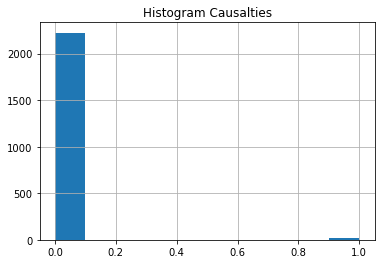

In [10]:
def disease_to_int(x):
    try:
        return int(x)
    except:
        return 0
    
data['disease_encoded']= data['disease'].apply(disease_to_int)
data['disease_encoded'].hist()
plt.gcf()
plt.title('Histogram Causalties')

Everything makes sense. There are two cases we do not have any information, and there are people who died first and later they were comfirmed.

In [11]:
data[['state','days_death_confirmed',
        'days_death_symptons','confirmed_date','released_date',
        'symptom_onset_date','deceased_date']].head()

,state,days_death_confirmed,days_death_symptons,confirmed_date,released_date,symptom_onset_date,deceased_date
0,released,NaT,NaT,2020-01-23,2020-02-05,2020-01-22,NaT
1,released,NaT,NaT,2020-01-30,2020-03-02,NaT,NaT
2,released,NaT,NaT,2020-01-30,2020-02-19,NaT,NaT
3,released,NaT,NaT,2020-01-30,2020-02-15,2020-01-26,NaT
4,released,NaT,NaT,2020-01-31,2020-02-24,NaT,NaT


In [12]:
#data_fileted = data[(data['state']=='deceased')  |  (data['state']=='isolated')].copy()
data_fileted = data[(data['state']=='deceased')].copy()
data_fileted['duration']= data_fileted['end_date'] - data_fileted['start_date']
data_fileted['observed']= (data['state']=='deceased')
data_fileted['observed'] = data_fileted['observed'].astype(int)
data_fileted.dropna(subset = ['observed','duration'],inplace = True)

In [13]:
data_fileted.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,...,released_date,deceased_date,state,days_death_confirmed,days_death_symptons,start_date,end_date,disease_encoded,duration,observed
405,1200000038,38.0,female,1963.0,50s,Korea,Daegu,Nam-gu,True,NaN,...,NaT,2020-02-23,deceased,5 days,NaT,2020-02-18,2020-02-23,1,5 days,1
444,1200000114,114.0,male,1946.0,70s,Korea,Daegu,NaN,NaN,Shincheonji Church,...,NaT,2020-02-26,deceased,5 days,NaT,2020-02-21,2020-02-26,0,5 days,1
445,1200000620,620.0,male,1949.0,70s,Korea,Daegu,NaN,NaN,NaN,...,NaT,2020-03-02,deceased,7 days,NaT,2020-02-24,2020-03-02,0,7 days,1
446,1200000901,901.0,female,1934.0,80s,Korea,Daegu,NaN,NaN,NaN,...,NaT,2020-03-04,deceased,8 days,NaT,2020-02-25,2020-03-04,0,8 days,1
447,1200001064,1064.0,female,1943.0,70s,Korea,Daegu,NaN,NaN,NaN,...,NaT,2020-03-01,deceased,4 days,NaT,2020-02-26,2020-03-01,0,4 days,1


In [14]:
data_fileted[['duration','observed']].describe()

,duration,observed
count,30,30.0
mean,3 days 06:24:00,1.0
std,2 days 20:26:44.155809,0.0
min,-1 days +00:00:00,1.0
25%,1 days 00:00:00,1.0
50%,3 days 12:00:00,1.0
75%,5 days 18:00:00,1.0
max,8 days 00:00:00,1.0


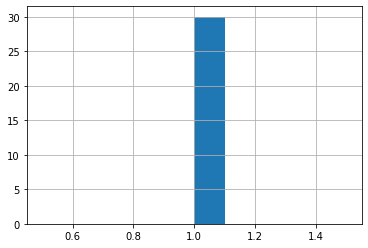

In [15]:
data_fileted['observed'].hist()

In [16]:
kmf = KaplanMeierFitter()
# Remove people with -1 timedelta
data_fileted = data_fileted[data_fileted["duration"]>= np.timedelta64(0,'D')]
# from time format to int
data_fileted["duration"] = data_fileted["duration"].dt.days

T = data_fileted["duration"]
E = data_fileted["observed"]

kmf.fit(T, event_observed=E)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 28 total observations, 0 right-censored observations>

Distribution of the deaths

Text(0.5, 1.0, 'Distribution of Death by day')

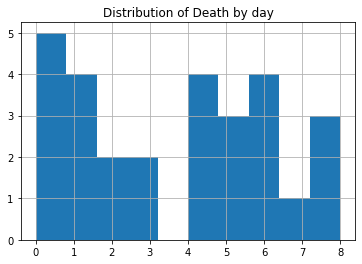

In [17]:
T.hist()
plt.gcf()
plt.title('Distribution of Death by day')

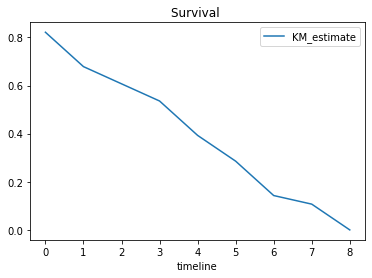

In [18]:
kmf.survival_function_.plot()
plt.title('Survival ');

Text(0.5, 1.0, 'Survival Function')

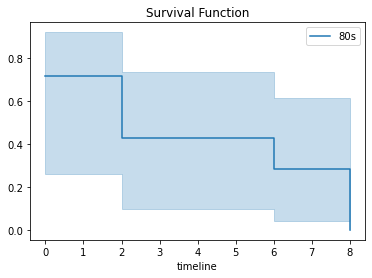

In [42]:
kmf.plot()
plt.gcf()
plt.title('Survival Function')

In [20]:
kmf.median_survival_time_

4.0

In [21]:

median_ci = median_survival_times(kmf.confidence_interval_)
median_ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,1.0,5.0


Mean of for and median sugguest 4 is the poing when most people decease.
# Gender differences

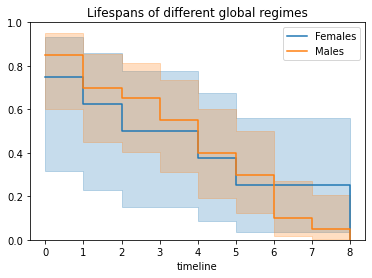

In [22]:
ax = plt.subplot(111)
dem = (data_fileted["sex"] == "female")
kmf.fit(T[dem], event_observed=E[dem], label="Females")
kmf.plot(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem], label="Males")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of different global regimes");

Text(0.5, 1.0, 'Gender Distribution')

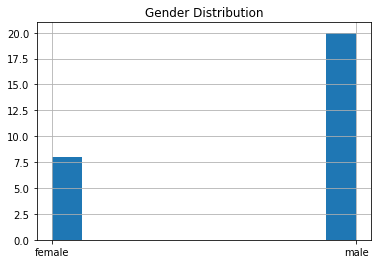

In [23]:
data_fileted["sex"].hist()
plt.gcf()
plt.title('Gender Distribution')

The graph suggest we cannot really distinguish by gender.
Let's check using a test (logrank_test). We do not found that the curves are diffirent statistically. See below p value.

In [24]:
results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
results.print_summary()

# People with previous diseases

In [25]:
data_fileted['disease_encoded']

405     1
444     0
445     0
446     0
447     0
448     1
449     0
450     1
451     1
452     0
453     1
454     0
455     0
456     0
457     0
458     1
459     1
460     1
461     1
462     1
652     1
942     1
1935    0
2049    1
2050    1
2052    1
2054    1
2055    1
Name: disease_encoded, dtype: int64

Text(0.5, 1.0, 'People with previous diseases cases')

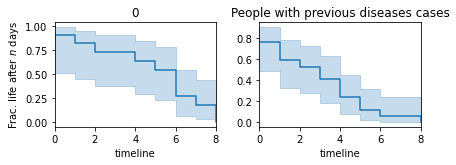

In [26]:

regime_types = [0,1]

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 2, i + 1)

    ix = data_fileted['disease_encoded'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 8)

    if i==0:
        plt.ylabel('Frac. life after $n$ days')
plt.gcf()
plt.tight_layout()
plt.title('People with previous diseases cases')

In [27]:
dem = (data_fileted["disease_encoded"] == 1)
results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
results.print_summary()

Significat differencest at a 95%.

# Age differences

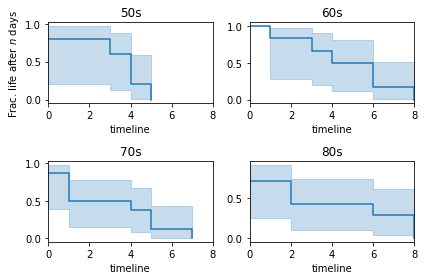

In [28]:
#regime_types = data_fileted['age'].unique()
regime_types = ['50s', '60s', '70s', '80s']

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 2, i + 1)

    ix = data_fileted['age'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 8)

    if i==0:
        plt.ylabel('Frac. life after $n$ days')

plt.tight_layout()

In [29]:
for i in regime_types:
    print('comparing age group {} vs all others'.format(i))
    dem = (data_fileted["age"] == i)
    results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)
    results.print_summary()

comparing age group 50s vs all others


comparing age group 60s vs all others


comparing age group 70s vs all others


comparing age group 80s vs all others


Groups are not significatively different. Probably because of the size of the sample.

In [30]:
dem_50s = (data_fileted["age"] == '50s')
dem_80s = (data_fileted["age"] == '80s')
results = logrank_test(T[dem_50s], T[dem_80s], E[dem_50s], E[dem_80s], alpha=.99)
results.print_summary()

[Estimating hazard rates using Nelson-Aalen](https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html#estimating-hazard-rates-using-nelson-aalen)

In [31]:
naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 28 total observations, 0 right-censored observations>

               80s
timeline          
0.0       0.309524
2.0       0.759524
6.0       1.092857
8.0       2.592857


Text(0.5, 1.0, 'Cumulative Hazard')

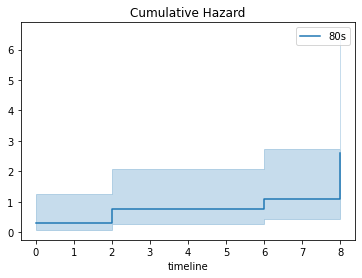

In [43]:
print(naf.cumulative_hazard_.head())
naf.plot()
plt.gcf()
plt.title('Cumulative Hazard')

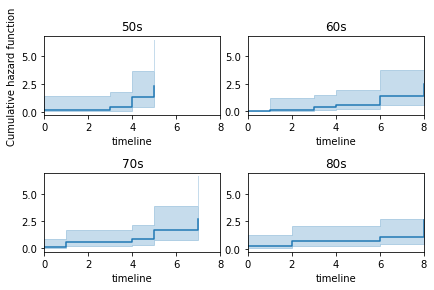

In [33]:
#regime_types = data_fileted['age'].unique()
regime_types = ['50s', '60s', '70s', '80s']

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 2, i + 1)

    ix = data_fileted['age'] == regime_type
    naf.fit(T[ix],event_observed=E[ix], label=regime_type)
    naf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 8)

    if i==0:
        plt.ylabel('Cumulative hazard function')

plt.tight_layout()

# Weibul Fiting Parametric 

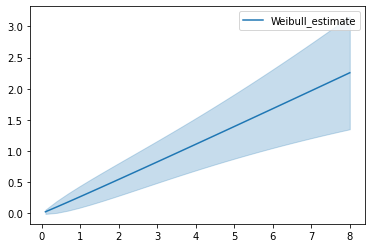

In [34]:
wf = WeibullFitter().fit(T.apply(lambda x: x if x>0 else x+0.1), E)
wf.print_summary()
wf.plot()
plt.gcf()
plt.title('Histogram Causalties')

# [Left Truncated data](https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html#left-truncated-late-entry-data)


In [35]:
data_fileted.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'days_death_confirmed',
       'days_death_symptons', 'start_date', 'end_date', 'disease_encoded',
       'duration', 'observed'],
      dtype='object')

In [36]:
data_fileted['duration']=data_fileted['duration']
data_fileted[['duration','observed']].dtypes

duration    int64
observed    int64
dtype: object

In [37]:
data_fileted['age_int']=data_fileted['age'].apply(lambda x: int(x.replace('s','')))

In [ ]:
# Basics of the Cox proportional hazards model
The purpose of the model is to evaluate simultaneously the effect of several factors on survival. In other words, it allows us to examine how specified factors influence the rate of a particular event happening (e.g., infection, death) at a particular point in time.
https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html
Really good explanations here :http://www.sthda.com/english/wiki/cox-proportional-hazards-model

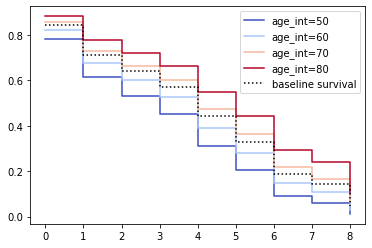

In [38]:
   
cph = CoxPHFitter()
cph.fit(data_fileted[['age_int','duration','observed']], duration_col='duration', event_col='observed')

cph.plot_covariate_groups('age_int', [50, 60, 70, 80], cmap='coolwarm')
plt.gcf()
plt.title('Histogram Causalties')

Looks like for younger people development could be shorter. Potentially because elder people could have go to the docter earlier. In order to better understand that let's have a look to the details. Looks like the variable may not be representative sinve p-value is 0.19

In [39]:
cph.print_summary()  # access the results using cph.summary

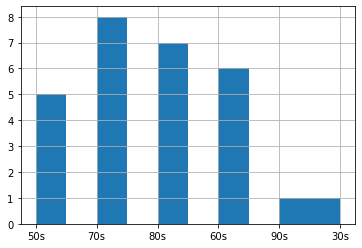

In [40]:
data_fileted['age'].hist()